In [219]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px

In [220]:
biometrics_df = df = pd.read_csv('biometrics_data.csv', delimiter=';')
biometrics_df.head()

,walking_type,video_id,person_id,camera_type,steps_length,avg_step_length,speed,time,distance,asymmetry
0,abnormal,limping1,0,front_multiple,[0.14770962 0.14714764 0.14685819 0.14727776 0...,0.158174,0.016143,324,5.230202,0.360017
1,abnormal,limping1,1,front_multiple,[0.2368916 0.15101376 0.15024317 0.15141071 0...,0.161374,0.025900,346,8.961452,0.802118
2,normal,DTU1,0,front,[0.11692207 0.13675987 0.14435628 0.15955304 0...,0.144130,0.043713,27,1.180249,0.039018
3,normal,jake,0,side,[0.55222212 0.61456363 0.56650746 0.60724509],0.585135,0.030833,58,1.788316,0.856048
4,normal,guy,0,side,[0.43892157 0.64519218 0.62339924 0.5295839 ],0.559274,0.035964,50,1.798175,0.714935


In [221]:
# Somehow the steps_length column is a string of a list of floats, so we need to convert it to a list of floats
biometrics_df["steps_length"] = biometrics_df["steps_length"].apply(
    lambda x: np.fromstring(x[1:-1], sep=" ")
)

# Rename side by side video
biometrics_df.loc[(biometrics_df['video_id'] == 'drunk_woman') & (biometrics_df['person_id'] == 0), 'camera_type'] = 'side'
biometrics_df.loc[(biometrics_df['video_id'] == 'drunk_woman') & (biometrics_df['person_id'] == 1), 'camera_type'] = 'front'

# Remove outlier
biometrics_df = biometrics_df[ (biometrics_df['video_id'] != 'DTU1') & (biometrics_df['asymmetry'] > -10.0)]

# Rename labels
replace = {"side2": "side", "front_multiple": "front", "back": "front", 'frontback': 'front'}
biometrics_df["camera_type"].replace(replace, inplace=True)

/var/folders/9m/g275tx_539v54jng1dk7_3m00000gn/T/ipykernel_1767/2498395683.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [222]:
clustering_df = biometrics_df.copy()
clustering_df["class"] = clustering_df["walking_type"] + "_" + clustering_df["camera_type"]
clustering_df = clustering_df[["class", "avg_step_length", "speed", "asymmetry"]]
clustering_df.head()

,class,avg_step_length,speed,asymmetry
0,abnormal_front,0.158174,0.016143,0.360017
1,abnormal_front,0.161374,0.025900,0.802118
3,normal_side,0.585135,0.030833,0.856048
4,normal_side,0.559274,0.035964,0.714935
5,normal_front,0.112751,0.014958,-0.023648


['abnormal_front', 'normal_side', 'normal_front', 'abnormal_side']
abnormal_front
normal_side
normal_front
abnormal_side


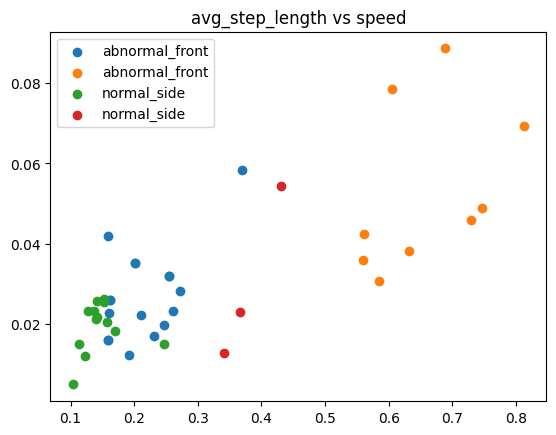

abnormal_front
normal_side
normal_front
abnormal_side


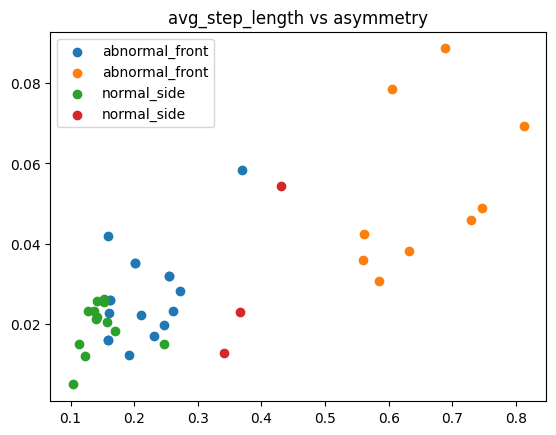

abnormal_front
normal_side
normal_front
abnormal_side


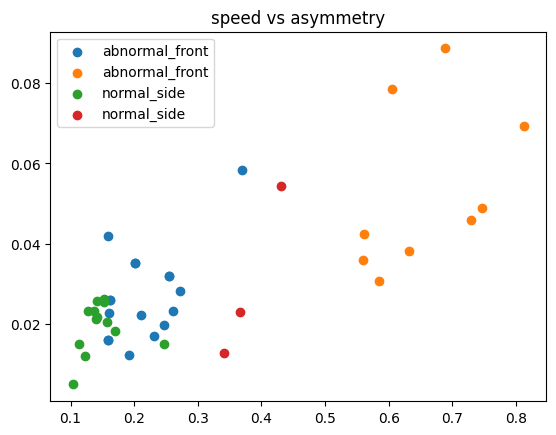

In [223]:
import matplotlib.pyplot as plt
import itertools


legend = list(clustering_df["class"].unique())
print(legend)

unique_numbers = {word: i for i, word in enumerate(set(clustering_df['class']))}

# Map the 'Fruit' column to unique numbers using the dictionary
clustering_df['numClass'] = clustering_df['class'].map(unique_numbers)

for item in itertools.combinations(["avg_step_length", "speed", "asymmetry"], r=2):
    fig, ax = plt.subplots()

    for class_label in legend:
        print(class_label)
        ax.scatter(clustering_df[clustering_df["class"] == class_label][attributes[0]], clustering_df[clustering_df["class"] == class_label][attributes[1]], label="class_label")

    ax.legend(clustering_df["class"].to_list())
    plt.title(item[0] + " vs " + item[1])
    plt.show()

In [224]:
legend

['abnormal_front', 'normal_side', 'normal_front', 'abnormal_side']

In [225]:
fig = px.scatter_3d(biometrics_df, x='avg_step_length', y='speed', z='asymmetry', color='camera_type', symbol='walking_type', width=1000, height=1000)
fig.show()

In [226]:
biometrics_df.head()

,walking_type,video_id,person_id,camera_type,steps_length,avg_step_length,speed,time,distance,asymmetry
0,abnormal,limping1,0,front,"[0.14770962, 0.14714764, 0.14685819, 0.1472777...",0.158174,0.016143,324,5.230202,0.360017
1,abnormal,limping1,1,front,"[0.2368916, 0.15101376, 0.15024317, 0.15141071...",0.161374,0.025900,346,8.961452,0.802118
3,normal,jake,0,side,"[0.55222212, 0.61456363, 0.56650746, 0.60724509]",0.585135,0.030833,58,1.788316,0.856048
4,normal,guy,0,side,"[0.43892157, 0.64519218, 0.62339924, 0.5295839]",0.559274,0.035964,50,1.798175,0.714935
5,normal,karolina,0,front,"[0.12800904, 0.07777523, 0.10063381, 0.0981336...",0.112751,0.014958,700,10.470564,-0.023648


In [227]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score


In [228]:
X = clustering_df[["avg_step_length", "speed", "asymmetry"]]
y = clustering_df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test

26    abnormal_front
14       normal_side
9     abnormal_front
27     abnormal_side
5       normal_front
Name: class, dtype: object

In [229]:
clf = svm.SVC(kernel="linear").fit(X_train, y_train)
accuracy_score(clf.predict(X_test), y_test)

# clf = KMeans(n_clusters=4)
# clf.fit(X_train, y_train)
# y_pred_test = kmeans.predict(X_test)

0.6

In [198]:


# test_accuracy = accuracy_score(y_test, y_pred_test)

# # Print the results
# print(f"Test Accuracy: {test_accuracy:.2f}")
print(y_pred_test)
print(y_test)

NameError: name 'y_pred_test' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['abnormal_front', 'normal_side', 'normal_front', 'abnormal_side']
('avg_step_length', 'speed')
0
1


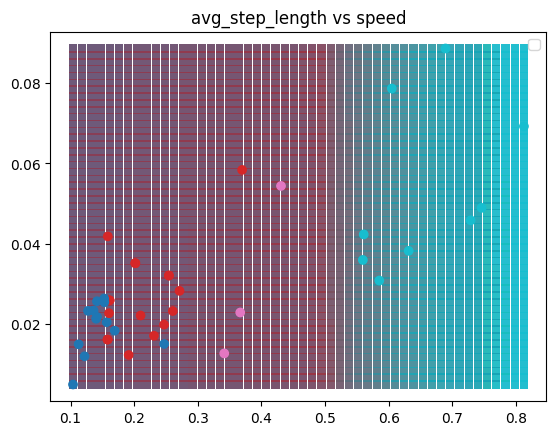

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('avg_step_length', 'asymmetry')
0
2


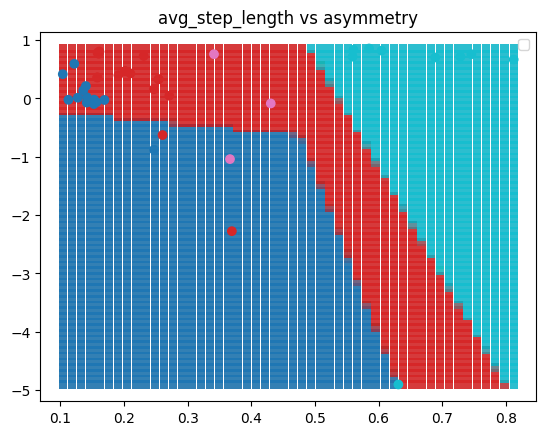

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('speed', 'asymmetry')
1
2


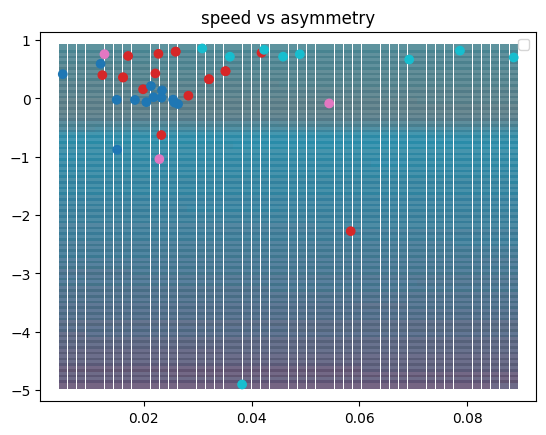

In [ ]:
import matplotlib.pyplot as plt
import itertools

legend = list(clustering_df["class"].unique())
print(legend)

unique_numbers = {word: i for i, word in enumerate(set(clustering_df['class']))}

clustering_df['numClass'] = clustering_df['class'].map(unique_numbers)
coords_df["numClass"] = coords_df['class'].map(unique_numbers)

for item in itertools.combinations(["avg_step_length", "speed", "asymmetry"], r=2):
    # fig, ax = plt.subplots()

    col1 = attributes.index(item[0])
    col2 = attributes.index(item[1])
    print(item)
    print(col1)
    print(col2)


    # for class_label in legend:
    #     print(class_label)
    #     ax.scatter(clustering_df[clustering_df["class"] == class_label][attributes[0]], clustering_df[clustering_df["class"] == class_label][attributes[1]], label="class_label")
    #     ax.scatter(coords_df[coords_df["class"] == class_label][attributes[0]], coords_df[coords_df["class"] == class_label][attributes[1]], label="class_label", alpha=0.04)

    # plt.scatter(coords_df[item[0]], coords_df[item[1]], c=coords_df["class"], cmap='tab10', alpha=0.04, marker="s", linewidths=0, edgecolors='none')
    plt.scatter(coords_df[item[0]], coords_df[item[1]], c=coords_df["numClass"], cmap='tab10', alpha=0.04, marker="s", linewidths=0, edgecolors='none')
    plt.scatter(clustering_df[item[0]], clustering_df[item[1]], c=clustering_df["numClass"], cmap='tab10')
    # plt.x_lab
    plt.legend()
    # ax.legend(clustering_df["class"].to_list())
    plt.title(item[0] + " vs " + item[1])
    plt.show()

In [ ]:
for i in itertools.combinations(["avg_step_length", "speed", "asymmetry"], r=2):
    print(i)

('avg_step_length', 'speed')
('avg_step_length', 'asymmetry')
('speed', 'asymmetry')


In [ ]:
coords_df[(coords_df["speed"] > 0.04678306119150835)]

,avg_step_length,speed,asymmetry,class,numClass
25,0.103900,0.047637,-4.905007,normal_front,0
26,0.103900,0.049344,-4.905007,normal_front,0
27,0.103900,0.051051,-4.905007,normal_front,0
28,0.103900,0.052759,-4.905007,normal_front,0
29,0.103900,0.054466,-4.905007,normal_front,0
...,...,...,...,...,...
149995,0.812373,0.081784,0.856048,normal_side,3
149996,0.812373,0.083491,0.856048,normal_side,3
149997,0.812373,0.085199,0.856048,normal_side,3
149998,0.812373,0.086906,0.856048,normal_side,3


In [ ]:
coords_df["speed"].median()

0.04678306119150835

In [230]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Set up the classifier
clf = svm.SVC(kernel="poly")

# Set up the k-fold cross-validation
k_fold = 10 # You can choose the number of folds as per your requirement

# Perform k-fold cross-validation and get accuracy scores
# Use 'scoring' parameter to specify the scoring metric (default is accuracy)
scores = cross_val_score(clf, X, y, cv=k_fold, scoring=make_scorer(accuracy_score))

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores)

# Print the mean and standard deviation of the accuracy scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation of accuracy:", np.std(scores))


Accuracy scores for each fold: [0.6  0.6  0.75 0.5  0.75 0.75 0.5  0.75 0.5  0.5 ]
Mean accuracy: 0.62
Standard deviation of accuracy: 0.11224972160321824


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



/var/folders/9m/g275tx_539v54jng1dk7_3m00000gn/T/ipykernel_1767/1236460935.py:94: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



Accuracy: 0.44


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



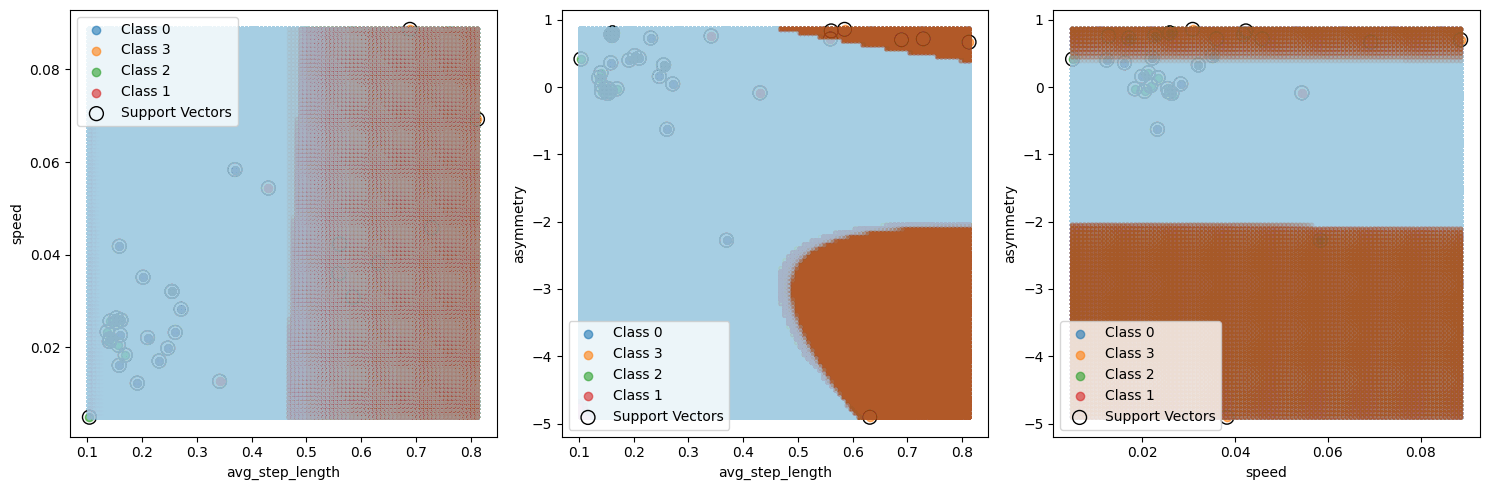

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a DataFrame named clustering_df
# Here's how to load or create it
# clustering_df = pd.read_csv('your_data.csv')  # Load your data from a CSV file
# or
# clustering_df = pd.DataFrame(...)  # Create your DataFrame with your data

# Encode the 'class' column to numerical values
label_encoder = LabelEncoder()
clustering_df['class_encoded'] = label_encoder.fit_transform(clustering_df['class'])

# Train-test split
X = clustering_df[['avg_step_length', 'speed', 'asymmetry']]
y = clustering_df['class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier

rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

svm = rbf
svm.fit(X_train, y_train)

# Create a 3D meshgrid for visualization
xx, yy, zz = np.meshgrid(
    np.linspace(X_train['avg_step_length'].min(), X_train['avg_step_length'].max(), 100),
    np.linspace(X_train['speed'].min(), X_train['speed'].max(), 100),
    np.linspace(X_train['asymmetry'].min(), X_train['asymmetry'].max(), 100)
)

# Create a DataFrame with meshgrid points
meshgrid_df = pd.DataFrame({
    'avg_step_length': xx.ravel(),
    'speed': yy.ravel(),
    'asymmetry': zz.ravel()
})

# Predict class labels for the meshgrid DataFrame
meshgrid_df['predicted_class'] = svm.predict(meshgrid_df)

# Pairwise combinations
combinations = [("avg_step_length", "speed"), ("avg_step_length", "asymmetry"), ("speed", "asymmetry")]

# Create subplots for visualizing decision boundaries in pairwise combinations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, (x_axis, y_axis) in enumerate(combinations):
    x_pairwise = meshgrid_df[[x_axis, y_axis]]
    
    for j, cls in enumerate(y.unique()):
        indices = (y_train == cls)
        axes[i].scatter(
            X_train.loc[indices, x_axis],
            X_train.loc[indices, y_axis],
            label=f'Class {cls}',
            alpha=0.6
        )
    
    # Visualize support vectors
    support_vectors = X_train.iloc[svm.support_]
    axes[i].scatter(
        support_vectors[x_axis],
        support_vectors[y_axis],
        s=100,
        facecolors='none',
        edgecolors='k',
        label='Support Vectors'
    )
    
    # Plot decision boundary based on the predicted class of meshgrid points
    axes[i].scatter(
        meshgrid_df[x_axis],
        meshgrid_df[y_axis],
        c=meshgrid_df['predicted_class'],
        cmap=plt.cm.Paired,
        marker='.',
        alpha=0.04
    )
    
    axes[i].set_xlabel(x_axis)
    axes[i].set_ylabel(y_axis)
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Calculate accuracy on the test set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.show()
